# Openset learning demo

Most is based on the paper:

Vaze, S., Han, K., Vedaldi, A. & Zisserman, A. Open-Set Recognition: a Good Closed-Set Classifier is All You Need? arXiv (2021) doi:10.48550/arxiv.2110.06207.

An important point is how to **organize the datasets and the models**:
$$D_{train} = \{(\vec{x_i}, y_i)\}_{i=1}^N \subset X \times C \text{, with } Model(\vec{x_i}) = p(y_i | \vec{x_i})$$
$$D_{test-closed} = \{(\vec{x_i}, y_i)\}_{i=1}^M \subset X \times C \text{, with } Model(\vec{x_i}) = p(y_i | \vec{x_i})$$
$$D_{test-open} = \{(\vec{x_i}, y_i)\}_{i=1}^{M'} \subset X \times (C \cup U) \text{, with } Model(\vec{x_i}) = (p(y_i | \vec{x_i}), S(y_i \subset C | \vec{x_i}))$$

It is trivial how to evaluate the `train` and `test-closed` scenarios.

First, let's pick the NDB1 problem and a positive and negative antigen.

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.config as config
import NegativeClassOptimization.preprocessing as preprocessing
import NegativeClassOptimization.ml as ml
import NegativeClassOptimization.visualisations as vis

/home/eugen/miniconda3/envs/ab-negative-training/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The closed-set loop allows to train a model that outputs logits and expits (probability estimations). We will leverage that later for the openset scenario.

In [ ]:
N = 10000

epochs = 5
learning_rate = 0.01
ag_pos = "1FBI"
ag_neg = "1NSN"

data_path = Path(config.DATA_SLACK_1_GLOBAL)

In [2]:
raise NotImplementedError("Adjust to new preprocess_data_for_pytorch_binary API")

df = utils.load_global_dataframe()
df_closed = df.loc[df["Antigen"].isin([ag_pos, ag_neg])].copy().sample(N)
df_open = df.loc[df["Antigen"].isin(config.ANTIGENS_OPENSET)].copy()
df_open = df_open.drop_duplicates(["Slide"], keep="first")
df_open = df_open.loc[~df_open["Slide"].isin(df_closed["Slide"])].sample(N)
df_open = df_open.reset_index(drop=True)

(   
    _,
    _,
    _,
    train_loader,
    test_loader,
    open_loader,
    ) = preprocessing.preprocess_data_for_pytorch_binary(
        df_closed,
        [ag_pos],
        scale_onehot=True,
        df_openset=df_open,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ml.SN10().to(device)

online_metrics = ml.train_for_ndb1(epochs, learning_rate, train_loader, test_loader, open_loader, model)
online_metrics

Using cpu device
SN10(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=220, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)
Epoch 1
-------------------------------
loss: 0.685306  [    0/ 6569]
loss: 0.642669  [ 6400/ 6569]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.641567 

Epoch 2
-------------------------------
loss: 0.635669  [    0/ 6569]
loss: 0.577157  [ 6400/ 6569]
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.570689 

Epoch 3
-------------------------------
loss: 0.572638  [    0/ 6569]
loss: 0.497943  [ 6400/ 6569]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.483437 

Epoch 4
-------------------------------
loss: 0.494594  [    0/ 6569]
loss: 0.421316  [ 6400/ 6569]
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.396786 

Epoch 5
-------------------------------
loss: 0.410968  [    0/ 6569]
loss: 0.357020  [ 6400/ 6569]
Test Error: 
 Accuracy:

Computing logits and expits.

In [3]:
with torch.no_grad():
    print(f"""
    Logits: {model.forward_logits(test_loader.dataset[0][0])}
    Absolute logits: {abs(model.forward_logits(test_loader.dataset[0][0]))}
    Expits: {model.forward(test_loader.dataset[0][0])}
    Expits and logits: {model.forward(test_loader.dataset[0][0], return_logits=True)}
    """)


    Logits: tensor([[1.8979]])
    Absolute logits: tensor([[1.8979]])
    Expits: tensor([[0.8696]])
    Expits and logits: (tensor([[0.8696]]), tensor([[1.8979]]))
    


Closed set and open set evaluation.

In [4]:
eval_metrics = ml.evaluate_on_closed_and_open_testsets(open_loader, test_loader, model)
eval_metrics

{'open': {'y_open_abs_logits': 0        1.483104
  1        0.559989
  2        0.445856
  3        0.575059
  4        0.197973
             ...   
  11637    0.563839
  11638    0.225798
  11639    1.151352
  11640    2.258636
  11641    0.819809
  Name: abs_logits, Length: 11642, dtype: float32,
  'y_open_true': 0        0
  1        0
  2        0
  3        0
  4        0
          ..
  11637    1
  11638    1
  11639    1
  11640    1
  11641    1
  Name: y, Length: 11642, dtype: int64,
  'roc_auc_open': 0.7386157734470158},
 'closed': {'y_test_logits': array([ 1.8978673,  0.4194428,  0.6839118, ..., -1.1513523, -2.2586358,
          0.8198087], dtype=float32),
  'y_test_pred': array([1., 1., 1., ..., 0., 0., 1.], dtype=float32),
  'y_test_true': array([1., 1., 1., ..., 0., 0., 0.], dtype=float32),
  'roc_auc_closed': 0.9665528508195188,
  'recall_closed': 0.9315589353612167,
  'precision_closed': 0.8941605839416058,
  'f1_closed': 0.9124767225325885}}

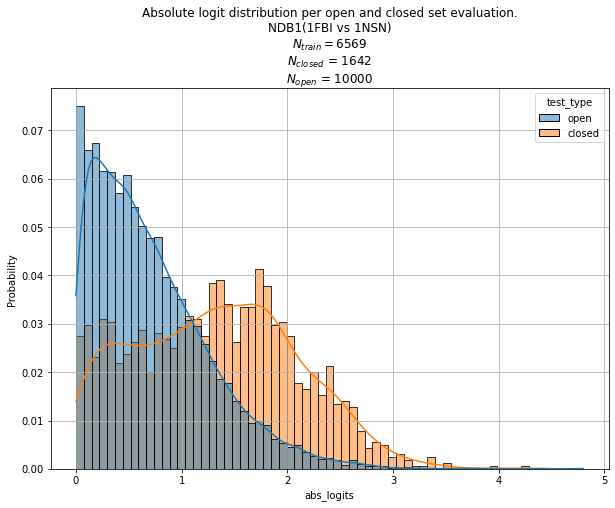

In [5]:
metadata={
    "ag_pos": ag_pos,
    "ag_neg": ag_neg,
    "N_train": len(train_loader.dataset),
    "N_closed": len(test_loader.dataset),
    "N_open": len(open_loader.dataset),
}

fig, ax = vis.plot_abs_logit_distr(
    eval_metrics, 
    metadata=metadata,
)
fig.show()

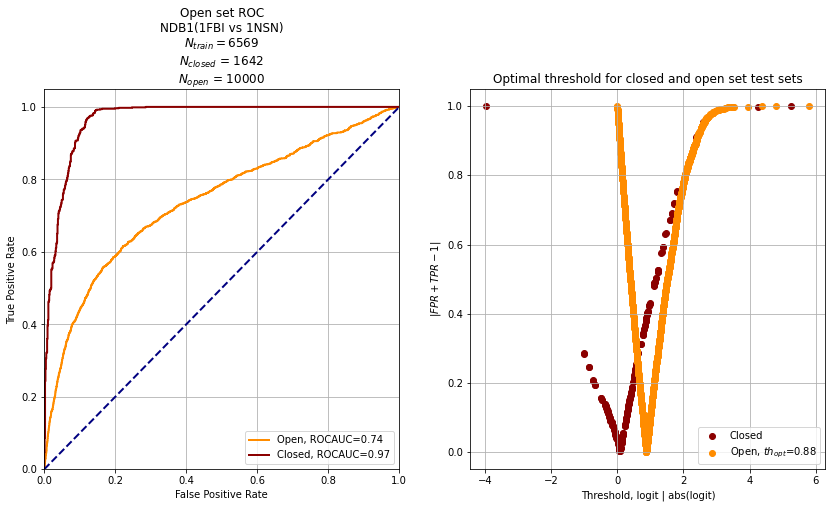

In [6]:
fig, _ = vis.plot_roc_open_and_closed_testsets(eval_metrics, metadata=metadata)
fig.show()